<a href="https://colab.research.google.com/github/JinGunseon/FinanceDataAnalysis/blob/main/%EC%8B%A4%EC%8A%B5_%ED%8F%AC%ED%8A%B8%ED%8F%B4%EB%A6%AC%EC%98%A4_%EC%B5%9C%EC%A0%81%ED%99%94%EC%99%80_%ED%9A%A8%EC%9C%A8%EC%A0%81_%ED%88%AC%EC%9E%90%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization (포트폴리오 최적화)

- 위험회피적 투자자가 시장 위험의 주어진 수준에 따라 기대수익을 최적화하거나 최대화하여 보상 수준을 선택  


- 방법 1 – Monte Carlo Simulation 에 의한 최적 포트폴리오 탐색
- 방법 2 – scipy 를 이용한 수학적 최적화 (Mathematical Optimization)

In [1]:
!pip install --upgrade Finance-Datareader
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (29.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and direc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import FinanceDataReader as fdr
import matplotlib as mpl
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # Colab 환경의 나눔고딕 폰트 경로

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib의 기본 폰트 설정
mpl.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [9]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2020,12, 31)

- portfolio 생성

In [11]:
# 종목 코드와 종목명을 리스트로 저장합니다.
# stock_list에는 ('종목 코드', '종목명')의 형태로 데이터가 저장되어 있습니다.
stock_list = [('000990', 'DB하이텍'), ('005930', '삼성전자'), ('016360', '삼성증권'), ('035720', '카카오')]

# 주가 데이터를 저장할 빈 데이터프레임을 생성합니다.
portfolio = pd.DataFrame([])

# stock_list에 있는 종목 코드와 종목명을 이용해 데이터를 반복 처리합니다.
for code, name in stock_list:
    # 종목의 종가 데이터를 FinanceDataReader를 통해 가져옵니다.
    df = fdr.DataReader(code, start, end)

    # 만약 데이터프레임(df)이 비어있다면, 해당 종목의 코드를 출력합니다.
    if len(df) == 0:
        print(code, name)

    # 종가 데이터를 portfolio 데이터프레임에 열(column)로 추가합니다.
    # concat 함수는 새로운 열을 수평 방향(axis=1)으로 추가합니다.
    portfolio = pd.concat([portfolio, df['Close']], axis=1)

# code_names에는 stock_list에서 종목명(name)만 따로 추출해 저장합니다.
code_names = [name for (code, name) in stock_list]

# portfolio 데이터프레임의 열 이름을 종목명 리스트로 변경합니다.
portfolio.columns = code_names

portfolio.head()

,DB하이텍,삼성전자,삼성증권,카카오
2020-01-02 00:00:00,27900,55200,37850,30609
2020-01-03 00:00:00,27600,55500,38100,30609
2020-01-06 00:00:00,28000,55500,37500,31010
2020-01-07 00:00:00,28000,55800,37800,32114
2020-01-08 00:00:00,28950,56800,37150,32014


- 포트폴리오 각 자산의 일일 log 수익률 생성 (daily log return)

In [12]:
log_return = np.log(portfolio / portfolio.shift(1))
log_return.head()

,DB하이텍,삼성전자,삼성증권,카카오
2020-01-02 00:00:00,NaN,NaN,NaN,NaN
2020-01-03 00:00:00,-0.010811,0.005420,0.006583,0.000000
2020-01-06 00:00:00,0.014389,0.000000,-0.015873,0.013016
2020-01-07 00:00:00,0.000000,0.005391,0.007968,0.034982
2020-01-08 00:00:00,0.033366,0.017762,-0.017345,-0.003119


asset 간의 상관 계수

In [14]:
log_return.corr()

,DB하이텍,삼성전자,삼성증권,카카오
DB하이텍,1.000000,0.513497,0.353162,0.494775
삼성전자,0.513497,1.000000,0.652664,0.346570
삼성증권,0.353162,0.652664,1.000000,0.239416
카카오,0.494775,0.346570,0.239416,1.000000


In [16]:
log_return.cov()

,DB하이텍,삼성전자,삼성증권,카카오
DB하이텍,0.001410,0.000403,0.000387,0.000475
삼성전자,0.000403,0.000437,0.000398,0.000185
삼성증권,0.000387,0.000398,0.000851,0.000179
카카오,0.000475,0.000185,0.000179,0.000654


## Method 1 - Monte Carlo Simulation

- 가능한 allocation 의 조합을 loop 로 반복하여 최적의 조합 (Highest Sharpe ratio) 을 찾는다.


$$Portfolio \ SR = \frac{(포트폴리오 \ 기대수익률 - 무위험수익률)}{포트폴리오\  기대수익률과 \ 무위험수익률\  공분산의 \ 표준편차}$$

$$SR=\frac{R_p - R_f}{\sigma_p}$$



위의 자산을 1/4 씩 동일 비중으로 포트폴리오 구성한 경우 portfolio 의 샤프 비율 계산

In [15]:
weights = np.array([0.25, 0.25, 0.25, 0.25])

**포트폴리오의 연간 covariance**

공분산(covariance)은 두 주식의 수익률 변동이 어떻게 관련되어 있는지 측정하는 지표입니다. 이 경우, 공분산은 제곱 단위으로 측정되므로 연간화할 때 제곱근을 사용하지 않고 거래일 수(일반적으로 252일)를 곱합니다.  

np.dot( ..., weights)는 두 배열의 내적을 계산합니다. 연간 공분산 행렬과 각 주식의 비중(weights)을 곱하여 포트폴리오 전체의 공분산을 계산합니다.

In [17]:
# 로그 수익률(log_ret) 데이터에서 연간 공분산 행렬을 계산한 후, 포트폴리오 가중치(weights)와 곱하여 전체 포트폴리오의 공분산을 계산합니다.
# log_ret.cov()는 로그 수익률의 공분산 행렬을 계산합니다.
# * 252는 주식시장이 1년에 252일 거래되기 때문에 연간 공분산을 계산하기 위한 보정입니다.
# np.dot()는 두 배열의 내적을 계산하는 함수로, 연간 공분산 행렬과 포트폴리오 가중치(weights)의 내적을 구합니다.

cov = np.dot(log_return.cov() * 252, weights)
cov

array([0.16857857, 0.08969351, 0.11430358, 0.09408011])

**포트폴리오의 연간 수익률 계산**

각 주식의 평균 로그 수익률에 그 주식이 포트폴리오에서 차지하는 비중을 곱한 후, 이를 모두 더하여(np.sum) 주식 포트폴리오의 일별 예상 수익률을 얻습니다. 그 후, 이 일별 예상 수익률을 연간화하기 위해 252를 곱합니다.

In [20]:
# 로그 수익률(log_ret)의 평균 수익률과 가중치(weights)를 곱하여 포트폴리오의 기대 수익률을 계산합니다.
# log_ret.mean()은 각 자산의 평균 로그 수익률을 계산합니다.
# * weights는 각 자산에 할당된 가중치를 반영하여 가중합을 구합니다.
# * 252는 주식시장이 1년에 252일 거래되기 때문에, 일간 수익률을 연간 수익률로 변환하기 위한 보정입니다.
ret = np.sum(log_return.mean() * weights) * 252
ret

np.float64(0.5077819881560465)

**포트폴리오의 연간 변동성 계산**

'np.dot(weights.T, cov)'는 가중치 벡터와 공분산 행렬의 내적을 계산하는 것으로, 이 값은 포트폴리오의 분산을 나타냅니다.

이 분산 값에 'np.sqrt' 함수를 적용하여 포트폴리오의 표준편차(또는 변동성)을 계산합니다. 이 값은 포트폴리오의 위험을 나타내며, 값이 클수록 포트폴리오의 위험이 크다는 것을 의미합니다.

In [21]:
# 포트폴리오의 연간 변동성(위험)을 계산합니다.
# weights.T는 포트폴리오 가중치 벡터의 전치 행렬(transpose)입니다.
# np.dot(weights.T, cov)은 포트폴리오 가중치와 공분산 행렬(cov)의 내적을 계산하여 포트폴리오의 분산을 구합니다.
# np.sqrt()는 이 값을 제곱근으로 변환하여 포트폴리오의 변동성(volatility, vol)을 계산합니다.
vol = np.sqrt(np.dot(weights.T, cov))
vol

np.float64(0.34156103832575646)

**포트폴리오의 샤프지수**

In [22]:
# 포트폴리오의 수익률 대비 변동성 비율을 계산
# ret은 포트폴리오의 연간 기대 수익률을 의미하고, vol은 포트폴리오의 연간 변동성(위험)을 의미
# ret / vol은 변동성(위험) 한 단위당 기대 수익률을 나타내며, 이는 포트폴리오의 효율성을 평가하는 지표로 사용됩니다.
# 수익률 대비 변동성 비율을 출력합니다.
performance_ratio = ret / vol
performance_ratio

np.float64(1.4866507920372358)

### 모든 내용을 집합하여 샤프비율 계산 함수 작성
    반환값 - 연간 기대 수익률, 연간 covariance, sharp ratio 반환

In [23]:
def get_ret_vol_sr(weights, log_return):
    # 가중치를 numpy array로 변환
    weights = np.array(weights)


    # 각 주식의 로그 수익률에 대한 공분산을 계산하고, 가중치를 곱한 후 연간화
    cov = np.dot(log_return.cov() * 252, weights)

    # 각 주식의 평균 로그 수익률에 가중치를 곱한 후 합산하여 포트폴리오의 일별 예상 수익률을 구하고, 이를 연간화
    ret = np.sum(log_return.mean() * weights) * 252

    # 포트폴리오의 분산을 계산한 후, 이의 제곱근을 구하여 포트폴리오의 변동성(표준편차)를 계산
    vol = np.sqrt(np.dot(weights.T, cov))

    # 포트폴리오의 수익률을 변동성으로 나누어 샤프 지수를 계산
    sr = ret / vol

    # 수익률, 변동성, 샤프 지수를 원소로 하는 numpy array를 반환
    return np.array([ret, vol, sr])

In [24]:
get_ret_vol_sr(weights, log_return)

array([0.50778199, 0.34156104, 1.48665079])

**MC Simulation - 각 자산의 비중을 무작위로 선택하여 특정 자산 비중에서의 연간 수익률, 변동성, 샤프비율 계산**

주어진 주식 포트폴리오에 대해 각각 랜덤한 가중치를 할당하여 해당 가중치에서의 예상 수익률, 변동성, 샤프 지수를 계산하고, 이를 각각의 배열에 저장하는 과정을 반복적으로 수행합니다. 이렇게 하면 랜덤한 가중치 조합에 대한 포트폴리오 성능을 시뮬레이션하여 최적의 포트폴리오를 탐색하는 데 도움이 됩니다.

In [25]:
# 랜덤 시드 설정
np.random.seed(101)

# 주식의 개수를 구합니다.
cols = len(log_return.columns)

# 반복 횟수 설정
iteration = 50_000

# 결과를 저장할 배열 초기화
all_weights = np.zeros((iteration, cols))
ret_arr = np.zeros(iteration)
vol_arr = np.zeros(iteration)
sharpe_arr = np.zeros(iteration)

# 반복 횟수만큼 반복
for i in range(iteration):
    # 각 주식에 대한 가중치를 랜덤하게 생성
    weights = np.random.random(cols)

    # 가중치의 합이 1이 되도록 스케일링
    weights = weights / np.sum(weights)

    # 이번 반복에서의 가중치 저장
    all_weights[i, :] = weights

    # 주어진 가중치에서의 수익률, 변동성, 샤프 지수 계산
    rvs = get_ret_vol_sr(weights, log_return)

    # 결과 저장
    ret_arr[i] = rvs[0]
    vol_arr[i] = rvs[1]
    sharpe_arr[i] = rvs[2]

In [26]:
sharpe_arr

array([1.46645523, 1.76652878, 1.27942786, ..., 1.55566596, 1.40503513,
       1.37748793])

- 최적 샤프 비율 (highest sharpe ratio)을 구하고, 그 때의 최적 자산 배분 비율을 구함

In [27]:
# MC method 에 의해 simulation 한 최적 sharpe ratio
sharpe_arr.max()

np.float64(2.3860838689567987)

In [31]:
max_idx = sharpe_arr.argmax()

In [29]:
sharpe_arr[13988]

np.float64(2.3860838689567987)

최적 Sharpe ratio 일 때의 daily return 과 volatility, 최적 portfolio 비율

In [32]:
print('return = {}'.format(ret_arr[max_idx]))
print('volatility = {}'.format(vol_arr[max_idx]))

with np.printoptions(precision=5, suppress=True):
    print('최적 자산 배분 비율 = {} : {}'.format(log_return.columns.values, all_weights[max_idx]))

return = 0.8642663867488267
volatility = 0.36221123573778063
최적 자산 배분 비율 = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.00079 0.16159 0.00088 0.83674]


- 포트폴리오 조합 및 최적 포트폴리오 시각화

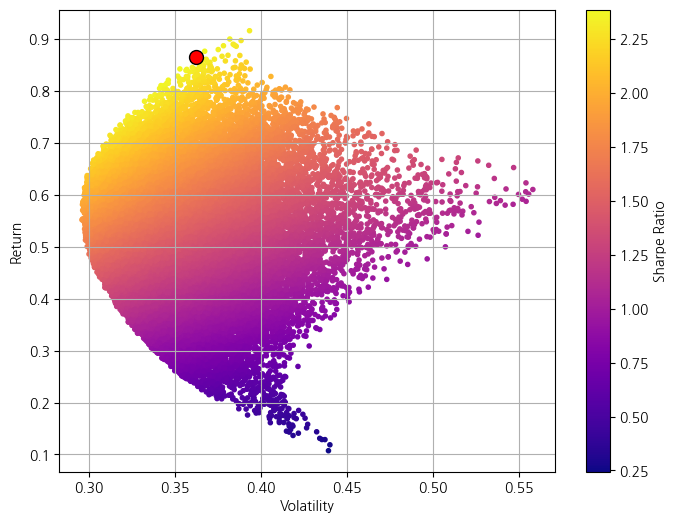

In [37]:
plt.figure(figsize=(8, 6))

# 포트폴리오의 변동성(vol_arr)과 수익률(ret_arr)을 산점도로 시각화합니다.
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, marker='.', cmap='plasma')

# c=sharpe_arr는 샤프 비율 배열을 색으로 사용하여 각 포트폴리오의 효율성을 시각적으로 나타냅니다.
plt.colorbar(label='Sharpe Ratio')
# marker='.'는 점으로 표시, cmap='plasma'는 색상 팔레트를 설정합니다.
# 색상 바를 추가하여 샤프 비율(Sharpe Ratio)을 시각적으로 표시합니다.
# 그리드를 추가하여 그래프를 보기 쉽게 만듭니다.
plt.grid()
# x축 레이블을 'Volatility'(변동성)으로 설정합니다.
plt.xlabel('Volatility')
# y축 레이블을 'Return'(수익률)으로 설정합니다.
plt.ylabel('Return')
# 최적의 포트폴리오를 표시합니다.
# 최적 포트폴리오는 샤프 비율이 가장 높은 포트폴리오로, 그 좌표(vol_arr[max_idx], ret_arr[max_idx])를 빨간색 원('ro')으로 표시합니다.
# markeredgecolor='k'는 마커의 테두리를 검은색으로 설정, markersize=10은 마커의 크기를 10으로 설정합니다.
plt.plot(vol_arr[max_idx], ret_arr[max_idx], 'ro', markeredgecolor = 'k', markersize=10)

## Method 2 - Scipy 를 이용한 수학적 최적화 (Mathematical Optimization)

수학적 최적화는 주어진 제약 조건 아래에서 목표 함수를 최대화 또는 최소화하는 입력 값(변수)을 찾는 과정입니다. 예를 들어, 포트폴리오 최적화에서 목표 함수는 샤프 지수(포트폴리오의 예상 수익률을 변동성으로 나눈 값)이며, 제약 조건은 포트폴리오의 총 가중치가 1이 되어야 한다는 것입니다.

Scipy는 수치 계산을 위한 파이썬 라이브러리로, 여러 종류의 최적화 알고리즘을 제공합니다. `scipy.optimize` 모듈에서 이 알고리즘들을 사용할 수 있습니다. 이 알고리즘들은 목표 함수와 초기 점, 제약 조건 등을 입력으로 받아 최적의 해를 찾아냅니다.

포트폴리오 최적화에서는 다음과 같은 과정으로 진행됩니다:

1. 목표 함수 정의: 샤프 지수를 최대화하는 것이 목표입니다. 이를 위해 예상 수익률, 변동성 등을 계산하는 함수를 정의합니다.
2. 초기 점 설정: 최적화 알고리즘은 초기 점에서 시작해 최적의 해를 찾아냅니다. 주식의 가중치를 동일하게 설정하는 것이 일반적입니다.
3. 제약 조건 설정: 포트폴리오의 총 가중치가 1이 되도록 제약 조건을 설정합니다.
4. 최적화: Scipy의 최적화 함수를 호출하여 최적의 해를 찾습니다. 이때 목표 함수, 초기 점, 제약 조건 등을 입력으로 제공합니다.

이렇게 하면 최적의 포트폴리오, 즉 샤프 지수를 최대화하는 주식의 가중치를 찾을 수 있습니다. 이를 통해 포트폴리오의 수익률을 최대한 높이고 변동성을 최소화하는 투자 전략을 수립할 수 있습니다.

**Sharpe ratio 의 maximize 를 minimize 함수로 하므로 sharpe ratio * (-1) 을 minimize 하는 trick 을 이용한다.**

In [40]:
from scipy.optimize import minimize

# 목적 함수 정의 - 샤프비율 최대화

# weights는 각 자산의 비중을 나타냅니다.
# get_ret_vol_sr 함수는 수익률, 변동성, 샤프 비율을 반환하는 함수로,
# [2]는 샤프 비율을 의미합니다. 샤프 비율을 최대화하기 위해 음수를 반환합니다.
# 최적화 과정에서 최소화를 수행하므로 샤프 비율을 최대화하려면 음수로 변환하여 최소화합니다.
def neg_sharpe(weights):
  return get_ret_vol_sr(weights, log_return)[2] * -1

# 제약 조건 함수 정의
# 각 자산의 비중(weights)의 합이 1이어야 함을 보장합니다.
def check_sum(weights):
    # 자산 비중의 합이 1이면 0을 반환하여 제약 조건을 만족시킵니다.
    return np.sum(weights) - 1

# 제약 조건 설정
# 'eq'는 방정식 제약 조건을 의미하며, 자산 비중 합이 1이어야 함을 의미합니다.
cons = ({'type': 'eq', 'fun': check_sum})

# 각 자산의 비중에 대한 경계 설정
# 각 자산의 비중은 최소 0에서 최대 1 사이로 제한됩니다.
bounds = tuple((0, 1) for _ in log_return.columns)

# 각 자산의 초기 비중을 동일하게 설정
x0 = [1/len(log_return.columns) for _ in log_return.columns]

# 자산의 초기 비중을 동일하게 설정하여, 각 자산에 대해 1/자산 수만큼의 비중을 할당합니다.
# scipy의 minimize 함수를 사용하여 최적화 수행
# neg_sharpe 함수는 최소화할 대상 함수이고,
# x0는 초기 비중, method는 SLSQP(Sequential Least Squares Programming) 알고리즘을 사용,
# bounds는 자산 비중의 경계, constraints는 제약 조건을 나타냅니다.
opt_results = minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=cons)

# 최적화 결과를 출력합니다.
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.387747822387655
       x: [ 1.393e-17  1.853e-01  1.031e-16  8.147e-01]
     nit: 6
     jac: [ 4.574e-01 -1.583e-03  8.446e-01  3.582e-04]
    nfev: 31
    njev: 6

- x: objective function을 minimize (Sharpe Ratio를 최대화)하는 x 값 (asset weights)
- fun : 최적화 알고리즘이 찾은 최적 해에서의 목표 함수(neg_sharpe)의 값. 즉, 최적화된 포트폴리오에서의 샤프 비율의 음수

- MC method로 구한 결과와 수학적 optimize 결과가 유사하면 successful result 이다.

In [41]:
with np.printoptions(precision=5, suppress=True):
    print('scipy를 이용한 최적 자산 비중 = {} : {}'.format(log_return.columns.values, opt_results.x))
    print('MC를 이용한 최적 자산 비중    = {} : {}'.format(log_return.columns.values, all_weights[max_idx]))

scipy를 이용한 최적 자산 비중 = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.      0.18533 0.      0.81467]
MC를 이용한 최적 자산 비중    = ['DB하이텍' '삼성전자' '삼성증권' '카카오'] : [0.00079 0.16159 0.00088 0.83674]


- optimum asset weights 일 때의 return, volatility, sharpe ratio 구하기

In [50]:
opt_rvs = get_ret_vol_sr(opt_results.x, log_return)

with np.printoptions(precision=3, suppress=True):
    print('최적 자산 비중 {}: {} 일 때'.format(log_return.columns.values, opt_results.x))
    print('최적 Sharpe Ratio = {:.3f}'.format(opt_rvs[2]))
    print('최적 SR일 때의 수익률 = {:.3f}'.format(opt_rvs[0]))
    print('최적 SR일 때의 변동성 = {:.3f}'.format(opt_rvs[1]))

최적 자산 비중 ['DB하이텍' '삼성전자' '삼성증권' '카카오']: [0.    0.185 0.    0.815] 일 때
최적 Sharpe Ratio = 2.388
최적 SR일 때의 수익률 = 0.852
최적 SR일 때의 변동성 = 0.357


## Efficient Frontier (효율적 투자선)

- Efficient Frontier 는 정의된 수준의 위험 또는 주어진 기대수익 수준의 가장 낮은 위험에 대해 가장 높은 수익률을 제공하는 최적 포트폴리오 세트이다.

- 효율적 전선 아래에 있는 포트폴리오는 동일한 위험 수준에 대해 효율적 전선 상의 포트폴리오 보다 낮은 수익을 제공하므로 최선의 포트폴리오가 아님. 효율적 전선 오른쪽의 포트폴리오는 동일한 수익에 대해 위험 수준이 높으므로 최선의 포트폴리오가 아님.

<img src="https://i.imgur.com/f5l3zG0.png" width=450 />

In [45]:
# 목적 함수 설정 - 특정 자산 비중(weights)에서 가장 낮은 변동성을 찾는 함수
# weights는 각 자산의 비중을 나타냅니다.
# get_ret_vol_sr 함수는 수익률, 변동성, 샤프 비율을 반환하는 함수입니다.
# [1]은 변동성(volatility)을 의미하며, 이 변동성을 최소화하는 것이 이 함수의 목적입니다.
def minimize_volatility(weights):
  return get_ret_vol_sr(weights, log_return)[1]

In [46]:
# 최적화 함수
# possible_return 값에 따라 변동성을 최소화하는 최적의 자산 비중을 찾습니다.
def optimized_result(possible_return):
    # 제약 조건 설정
    # 첫 번째 제약 조건: 자산 비중의 합이 1이 되어야 함 (check_sum 함수 사용)
    # 두 번째 제약 조건: 기대 수익률이 가능한 수익률(possible_return)과 같아야 함
    cons = ({'type': 'eq', 'fun': check_sum},
            {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w, log_return)[0] - possible_return})

    # minimize 함수를 사용하여 변동성을 최소화하는 최적의 자산 비중을 찾습니다.
    # minimize_volatility 함수는 변동성을 최소화하는 함수,
    # x0는 초기 자산 비중, method='SLSQP'는 Sequential Least Squares Programming 알고리즘 사용,
    # bounds는 각 자산 비중의 경계를 설정하며, constraints는 제약 조건을 의미합니다.
    results = minimize(minimize_volatility, x0, method='SLSQP', bounds=bounds, constraints=cons)

    # 최적화 결과 반환
    return results

- possible return이 frontier_y일 때의 volatility를 구한다.  
- optimized_result 의 fun 이 목적함수의 반환값 $\rightarrow$ 즉, volatility 값  
    - fun : 최적화 알고리즘이 찾은 최적 해에서의 목표 함수(minimize_volatility)의 값
    - x : 자산 비중

In [44]:
# return 의 시각화 범위 설정
frontier_y = np.linspace(0.01, 0.90, 100)

- 모든 return (frontier_y)에 대한 volatility 를 구함

In [47]:
# 효율적 투자선의 변동성 값을 저장할 리스트를 초기화합니다.
frontier_volatility = []
# 주어진 기대 수익률 리스트 frontier_y에 대해 반복하며 변동성을 계산합니다.
for possible_return in frontier_y:
    result = optimized_result(possible_return)

    # 각 기대 수익률(possible_return)에 대해 변동성을 최소화하는 최적의 자산 비중을 찾습니다.
    # 최적화 결과에서 변동성 값을 리스트에 추가합니다.
    # result.fun은 최적화된 변동성 값(목표 함수의 값)을 의미합니다.
    frontier_volatility.append(result['fun'])

# 계산된 효율적 투자선의 변동성 값 중 처음 5개의 값을 출력합니다.
frontier_volatility[:5]

[np.float64(0.46304019077489256),
 np.float64(0.46304019077488745),
 np.float64(0.4630401907748899),
 np.float64(0.463040190774911),
 np.float64(0.463040190774879)]

- 모든 possible return 과 volatility를 연결하는 plot 시각화.

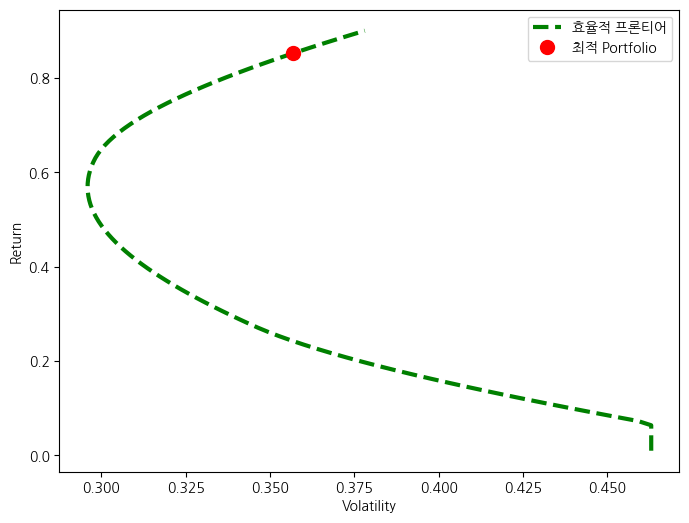

In [51]:
plt.figure(figsize=(8, 6))

# 효율적 투자선(Efficient Frontier)을 시각화합니다.
# frontier_volatility는 각 기대 수익률에 대응하는 변동성 값의 리스트입니다.
# frontier_y는 기대 수익률을 나타냅니다.
# 'g--'는 초록색 점선으로 그래프를 그리며, linewidth=3은 선의 굵기를 지정합니다.
# label='Efficient Frontier'는 범례에 'Efficient Frontier'로 표시됩니다.
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3, label='효율적 프론티어')

# 최적 포트폴리오를 시각화합니다.
# opt_rvs[1]은 최적 포트폴리오의 변동성(Volatility), opt_rvs[0]은 최적 포트폴리오의 수익률(Return)입니다.
# 'ro'는 빨간색 원 마커로 최적 포트폴리오를 표시하며, markersize=10은 마커 크기를 지정합니다.
# label='Optimum Portfolio'는 범례에 'Optimum Portfolio'로 표시됩니다.
plt.plot(opt_rvs[1], opt_rvs[0], 'ro', markersize=10, label='최적 Portfolio')

# x축 레이블을 'Volatility'(변동성)으로 설정합니다.
plt.xlabel('Volatility')

# y축 레이블을 'Return'(수익률)으로 설정합니다.
plt.ylabel('Return')

# 범례를 그래프에 추가합니다.
plt.legend()
plt.show()

### Method 1, 2 를 함께 시각화하여 결과 비교

In [ ]:
# 몬테카를로(MC) 시뮬레이션을 사용하여 포트폴리오의 변동성과 수익률을 산점도로 시각화
# vol_arr: 각 포트폴리오의 변동성 배열
# ret_arr: 각 포트폴리오의 수익률 배열
# c=sharpe_arr: 샤프 비율에 따라 색을 지정
# 최적의 포트폴리오를 파란색 원으로 표시
# vol_arr[max_idx], ret_arr[max_idx]: 최적 포트폴리오의 변동성과 수익률
# 색상 막대 추가하여 샤프 비율에 따른 색상 범위를 표시
# 수학적 방법으로 계산된 효율적 투자선(Efficient Frontier)을 녹색 점선으로 시각화
# frontier_volatility: 효율적 투자선의 변동성
# frontier_y: 효율적 투자선의 기대 수익률
# 수학적 방법으로 계산된 최적 포트폴리오를 빨간색 원으로 표시
# opt_rvs[1]: 최적 포트폴리오의 변동성
# opt_rvs[0]: 최적 포트폴리오의 기대 수익률

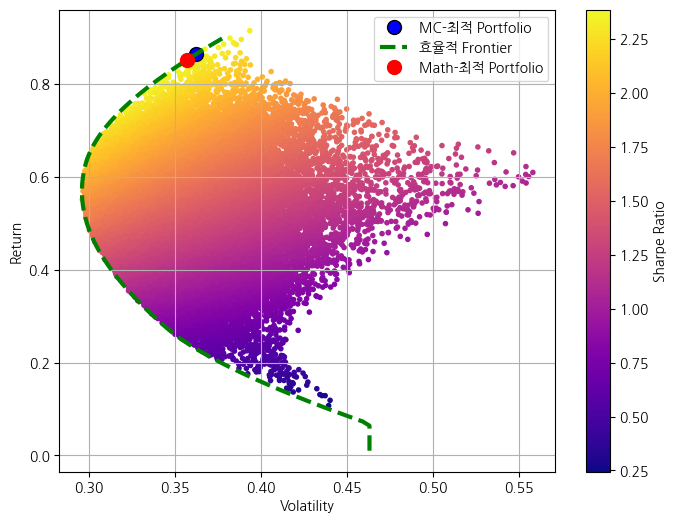

In [52]:
plt.figure(figsize=(8, 6))

# 몬테카를로(MC) 시뮬레이션을 사용하여 포트폴리오의 변동성과 수익률을 산점도로 시각화
# vol_arr: 각 포트폴리오의 변동성 배열
# ret_arr: 각 포트폴리오의 수익률 배열
# c=sharpe_arr: 샤프 비율에 따라 색을 지정
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, marker='.', cmap='plasma')

# 최적의 포트폴리오를 파란색 원으로 표시
# vol_arr[max_idx], ret_arr[max_idx]: 최적 포트폴리오의 변동성과 수익률
plt.plot(vol_arr[max_idx], ret_arr[max_idx], 'bo', markeredgecolor='k', markersize=10, label='MC-최적 Portfolio')

# 색상 막대 추가하여 샤프 비율에 따른 색상 범위를 표시
plt.colorbar(label='Sharpe Ratio')

# 수학적 방법으로 계산된 효율적 투자선(Efficient Frontier)을 녹색 점선으로 시각화
# frontier_volatility: 효율적 투자선의 변동성
# frontier_y: 효율적 투자선의 기대 수익률
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3, label='효율적 Frontier')

# 수학적 방법으로 계산된 최적 포트폴리오를 빨간색 원으로 표시
# opt_rvs[1]: 최적 포트폴리오의 변동성
# opt_rvs[0]: 최적 포트폴리오의 기대 수익률
plt.plot(opt_rvs[1], opt_rvs[0], 'ro', markersize=10, label='Math-최적 Portfolio')

plt.grid(True)

plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()